In [1]:
include("../scripts/tools.jl")
include("../scripts/get_grid.jl")
include("../scripts/get_params.jl")
include("../scripts/disc_solvers.jl");

In [2]:
dm = load_discrete_model("../data/disc/pantagruel.h5", 1.0);

[1]


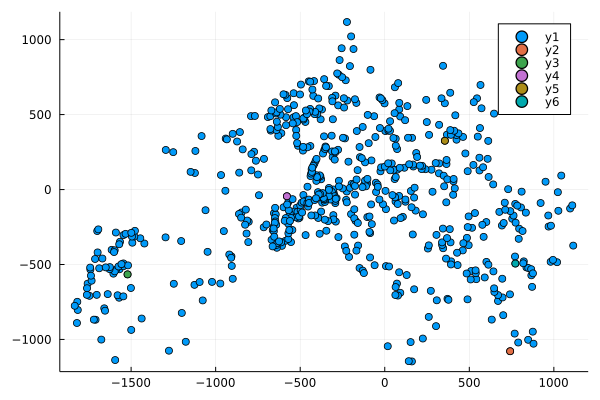

In [42]:
gps_coord = [37.90463686184484 22.81282645679302;]
id, idfault = find_gen(dm, gps_coord, 9.0, scale_factor=1.0)
println(idfault)
scatter(dm.coord[dm.idgen,2], dm.coord[dm.idgen,1])
scatter!(dm.coord[dm.idgen[id],2], dm.coord[dm.idgen[id],1])

In [4]:
Nbus = length(dm.load)
is_producing = dm.gen .> 0
id_gen = dm.idgen[is_producing]
id_load = setdiff(1:Nbus, id_gen)
#is_producing = data["gen"][:,2] .> 0
#id_gen = Int64.(data["gen"][is_producing, 1])
#id_load = setdiff(1:length(l), id_gen)
ng = length(id_gen)
nl = length(id_load)

#println(size(dm.idb))

g = zeros(Nbus)
g[dm.idgen] .= dm.gen
p = -dm.load + g
p .-= sum(p) / Nbus

og = zeros(ng)

edges = Int64.(zeros(size(dm.idb)))
line_start = dm.idb[:, 1]
line_end = dm.idb[:, 2]
# bus reordering: generator buses first 
for i in 1:ng
    edges[line_start .== id_gen[i], 1] .= i
    edges[line_end .== id_gen[i], 2] .= i
end
for i in 1:nl
    edges[line_start .== id_load[i], 1] .= i + ng
    edges[line_end .== id_load[i], 2] .= i + ng
end
nline = size(dm.idb,1)
id = edges
inc = sparse([id[:,1]; id[:,2]], [1:nline; 1:nline], [-ones(nline);ones(nline)])

# set initial conditions
og = zeros(ng)
thg = dm.th[id_gen]
thl = dm.th[id_load]
mg = dm.mg[is_producing]
dg = dm.dg[is_producing]
#dload = vec(data["load_freq_coef"])
dg += dm.dl[id_gen]
dl = dm.dl[id_load]
pg = p[id_gen]
pl = p[id_load]
p = [pg; pl];

In [11]:
# get the stable solution
b2 = - im .* dm.bline
Ybus = conj(inc * sparse(1:nline, 1:nline, b2) * inc')
q = zeros(Nbus)
V = ones(Nbus)
theta = zeros(Nbus)

V, theta, iter = NRsolver(Ybus, V, theta, -p, q, Array{Int64,1}([]), 1, tol = 1E-30, maxiter = 10)
#println(maximum(abs.(theta - [thg;thl])))
thg = theta[1:ng]
thl = theta[ng+1:end]

og = zeros(ng);

Max iteration reached, error: 2.456590486588084e-12


In [12]:
dt = 1e-3
Ndt = 25e3
interval = 100
ts = zeros(Int64.(floor(Ndt / interval))+1)
omegas = zeros(ng, Int64.(floor(Ndt / interval))+1)
k = 1
dp = zeros(ng)
dp[idfault[1]] = -9.0
#dp[1] = -9.0
for i in 1:Ndt
    y = radau5(og, thg, thl, mg, dg, dl, pg+dp, pl, inc, dm.bline, dt, maxiter = 14, tol = 1E-6)
    if(mod(i, interval) == 0)
        println(i, " / ", Ndt, " (", floor(100*i/Ndt), "%)")
            omegas[:, k+1] = y[1 : ng]
            ts[k+1] = i*dt
            k += 1
        end
    og = y[1:ng]
    thg = y[ng + 1 : 2 * ng]
    thl = y[2 * ng + 1 : end]
end
    

100.0 / 25000.0 (0.0%)
200.0 / 25000.0 (0.0%)
300.0 / 25000.0 (1.0%)
400.0 / 25000.0 (1.0%)
500.0 / 25000.0 (2.0%)
600.0 / 25000.0 (2.0%)
700.0 / 25000.0 (2.0%)
800.0 / 25000.0 (3.0%)
900.0 / 25000.0 (3.0%)
1000.0 / 25000.0 (4.0%)
1100.0 / 25000.0 (4.0%)
1200.0 / 25000.0 (4.0%)
1300.0 / 25000.0 (5.0%)
1400.0 / 25000.0 (5.0%)
1500.0 / 25000.0 (6.0%)
1600.0 / 25000.0 (6.0%)
1700.0 / 25000.0 (6.0%)
1800.0 / 25000.0 (7.0%)
1900.0 / 25000.0 (7.0%)
2000.0 / 25000.0 (8.0%)
2100.0 / 25000.0 (8.0%)
2200.0 / 25000.0 (8.0%)
2300.0 / 25000.0 (9.0%)
2400.0 / 25000.0 (9.0%)
2500.0 / 25000.0 (10.0%)
2600.0 / 25000.0 (10.0%)
2700.0 / 25000.0 (10.0%)
2800.0 / 25000.0 (11.0%)
2900.0 / 25000.0 (11.0%)
3000.0 / 25000.0 (12.0%)
3100.0 / 25000.0 (12.0%)
3200.0 / 25000.0 (12.0%)
3300.0 / 25000.0 (13.0%)
3400.0 / 25000.0 (13.0%)
3500.0 / 25000.0 (14.0%)
3600.0 / 25000.0 (14.0%)
3700.0 / 25000.0 (14.0%)
3800.0 / 25000.0 (15.0%)
3900.0 / 25000.0 (15.0%)
4000.0 / 25000.0 (16.0%)
4100.0 / 25000.0 (16.0%)
4200.0 /

In [35]:
fid = h5open("../numerics/disc_results.h5", "w")
write(fid, "ts", ts)
write(fid, "omegas", omegas)
write(fid, "idgen", id_gen)
close(fid)

In [39]:
idreverse = zeros(Int64, size(theta,1));

In [40]:
for i=1:size(id_gen,1)
    idreverse[id_gen[i]] = i
end
j = size(id_gen,1)+1
for i=1:size(id_load,1)
    idreverse[id_load[i]] = j
    j+=1
end

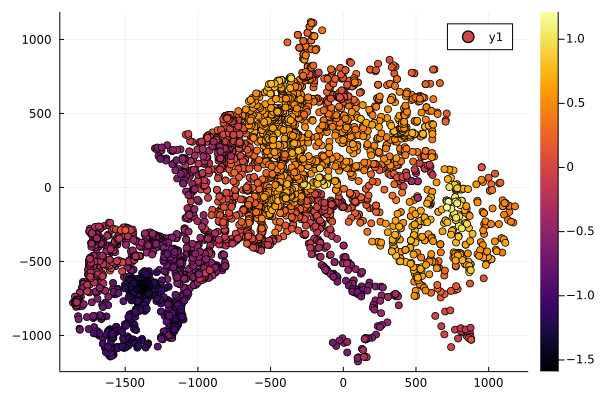

In [36]:
scatter(dm.coord[:,2], dm.coord[:,1], zcolor=dm.th)

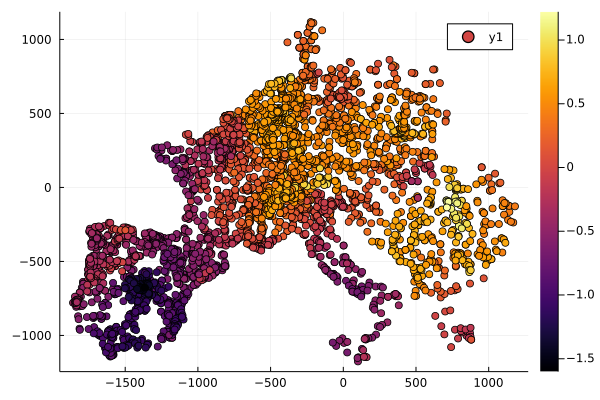

In [38]:
scatter(dm.coord[:,2], dm.coord[:,1], zcolor=theta[idreverse])